# Readme 

****************************
Motion detection project
****************************
ver. 5.0

Authors:

Anna Grzywa
Agnieszka Tracz
Adriana Zlahoda
Andrzej Czechowski
Michal Kluska
Maciej Stanuch
Adam Szmatula


This project is a data analysis of an 8-channels recorded EMG signal of 6 specific hand movements.
The 6 movements of 7 volunteers were registered as follows:

1. finger snap
2. hand shaking
3. double click betweem the thumb and the middle finger
4. right swap
5. left swap
6. fist

For every channel were defined the following  features:

12 time parameters were measured:
	maximum
	minimum
	mean
	std
	median
	median absolute deviation
	signal magnitude area
	energy
	interquartile range
	duration time
	entropy
	autocorrelation

4 frequency parameters:
	leading frequency
	weighted frequency
	skewness
	curtosis

The Pan-Tompkins algorithm was used to detect the beginning and end of the motion in the signal.

After calculating the average feature for each gesture for 5 out of 7 persons, 
a pattern was created and normalised to the [0, 1] range.

A transfer function was defined thanks to which each following motion
is normalised according to the pattern.

The feature vectors for each gesture for each person were compared 
with each base vector (pattern) by a scalar product.

The threshold is set in order to determine the similarity between the movements 
and qualify the correct gesture.

A statystical analysis was processed to check were the algorithm is correct and were it is not
by determining the accuracy, sensitivity and specificity but also a ROC curve.

It appears that the scalar product is the most efficient measure of similarity between vectors.

A PCA analysis of the feature vectors was processed to determine which parameter best determine a gesture.
Applying different weights to those parameters improves the algorithm efficiency
by discriminating the least influent parameters.


In [119]:
import numpy as np
import pandas as pd

import scipy.stats
import scipy.signal
import scipy.spatial.distance

import matplotlib.pyplot as plt
import matplotlib.mlab as mlab

import math
import os
import copy

import unittest

from matplotlib.path import Path
from matplotlib.spines import Spine
from matplotlib.projections.polar import PolarAxes
from matplotlib.projections import register_projection
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D

import pandas
from pandas.plotting import scatter_matrix
from sklearn import model_selection
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

from collections import defaultdict
from enum import Enum, IntEnum

def listdirNoHidden(path):
    result = []
    for f in os.listdir(path):
        if not f.startswith('.'):
            result.append(f)
    return result

In [120]:
class measType(Enum):
    accelerometer = 0
    emg = 1
    gyro = 2
    orientation = 3
    orientationEuler = 4

In [121]:
class MeasTypeFilter(): 
    def getKindOfMeas(self, filename):
        return filename.split('-')[-2].split('/')[-1]

    def getMeasByType(self, measType, data) :
        return list(filter(lambda x: self.getKindOfMeas(x) == measType.name, 
                           data))

In [122]:
class DataReader() : 
    def __init__ (self, path):
        self.__commonInitialization__()
        self.path = path
        self.readSubjectsList()
        self.readAllMeas()
        
    def __commonInitialization__(self):
        self.examinedSubjects = []
        self.personsGestures = []
        self.MeasurementsList = []
        self.measTypeFilter = MeasTypeFilter()

    def getAllPersonFiles(self, personId, gestureId, isShouldIncludeFullPath):
        if isShouldIncludeFullPath == True:
            return self.createFullPathToMeas(personId, gestureId,
                                             self.MeasurementsList[personId][gestureId])
        else:
            return self.MeasurementsList[personId][gestureId]
    
    def getSpecificPersonMeas(self, personId, gestureId, measType, isShouldIncludeFullPath):
        return self.measTypeFilter.getMeasByType(measType,
                                                 self.getAllPersonFiles(personId,
                                                                        gestureId,
                                                                        isShouldIncludeFullPath))                                                                                                 
    def readSubjectsList(self): 
        self.examinedSubjects = listdirNoHidden(path)
        self.personsGestures.clear()
        for subject in self.examinedSubjects:
            subjectList = listdirNoHidden(self.path + "/" + subject)
            self.personsGestures.append(subjectList)
                  
    def getDims(self, data):
        #getting dimension of folderListForPersons
        return np.shape(data)
    
    def readAllMeas(self): 
        self.MeasurementsList.clear()
        [self.noPerson, self.noGesture] = self.getDims(self.personsGestures)
        for personId in range(0, self.noPerson):
            personGestures = []
            for gestureId in range(0, self.noGesture):
                personGestures.append(listdirNoHidden(self.path + "/" + self.examinedSubjects[personId] + "/"  \
                                                        + self.personsGestures[personId][gestureId]))
            self.MeasurementsList.append(personGestures)
                                            
    def createFullPathToMeas(self, personId, gestureId, meas):
        return [self.path + "/" + self.examinedSubjects[personId] + "/" + \
               self.personsGestures[personId][gestureId] + "/" + \
               x for x in meas]

In [123]:
class Common:
    @staticmethod
    def index(array, item):
        for idx, val in np.ndenumerate(array):
            if val == item:
                return idx
            
    @staticmethod    
    def mad(data, axis = None):
        return np.mean(np.absolute(data - np.mean(data, axis)), axis)
    
    @staticmethod
    def sma(data):
        suma = np.sum(abs(data))
        dlugosc = np.size(data)
        return suma / dlugosc

    @staticmethod    
    def energy(data):
        suma = np.sum(pow(data, 2))
        dlugosc = np.size(data)
        return suma / dlugosc

    @staticmethod
    def iqr(data):
        q75, q25 = np.percentile(data, [75, 25])
        return q75 - q25
    
    @staticmethod
    def power(vector, power):
        return [ x ** power for x in vector ]
    
    @staticmethod
    def scalarSimilarity(vector1, vector2):
        result1 = np.dot(vector1, vector2)
        return result1 / (np.sqrt(sum(Common.power(vector1, 2))) * np.sqrt(sum(Common.power(vector2, 2))))
    
    @staticmethod
    def distanceSimilarity(vector1, vector2):
        return scipy.spatial.distance.pdist([vector1, vector2], 'euclidean')
    

In [124]:
def getSignalEnvelope(signal): 
    analyticalSignal = scipy.signal.hilbert(signal)
    return np.absolute(analyticalSignal)

In [125]:
class timeFeature(IntEnum):
    maximum = 0
    minimum = 1
    mean = 2
    std = 3
    median = 4
    mad = 5 #median absolute deviation
    sma = 6 #SignalMagnitudeArea
    energy = 7
    iqr = 8 # rozstep miedzykwartylowy
    durationTime = 9
    entropy = 10
    autocorrelation = 11
    
class frequencyFeature(IntEnum) :
    leadingFreq = 0
    weightedFreq = 1
    skewness = 2
    curtosis = 3
    
class envelopeFeature(IntEnum): 
    leadingFreq = 0
    
class FeaturesEnum(IntEnum): 
    maximum = 0
    minimum = 1
    mean = 2
    std = 3
    median = 4
    mad = 5 #median absolute deviation
    sma = 6 #SignalMagnitudeArea
    energy = 7
    iqr = 8 # rozstep miedzykwartylowy
    durationTime = 9
    leadingFreq = 10
    weightedFreq = 11
    skewness = 12
    curtosis = 13

class IFeatureExtractor: 
    def calculateFeatures(self, data, Fs):
        raise NotImplementedError 
     
    def getFeatureVec(self):
        raise NotImplementedError 

        
class TimeSeriesFeatureExtractor(IFeatureExtractor):
    def __init__(self): 
        IFeatureExtractor.__init__(self)
    
    def calculateFeatures(self, data, Fs): 
        maximum = np.max(data)
        minimum = np.min(data)
        mean = np.mean(data)
        std = np.std(data)
        median = np.median(data)
        mad = Common.mad(data)
        sma = Common.sma(data)
        energy = Common.energy(data)
        iqr = Common.iqr(data)
        durationTime = len(data) / Fs

        self.timeSeriesFeatures = [maximum, minimum, mean,
                                   std, median, mad, sma, energy,
                                   iqr, durationTime]
        
        return self.timeSeriesFeatures
            
    def getParameter(self, parameter):
        return self.timeSeriesFeatures[parameter]
    
    def getFeatureVec (self) : 
        return self.timeSeriesFeatures
    
class FrequencyFeatureExtractor(IFeatureExtractor):
    def __init__(self) : 
        IFeatureExtractor.__init__(self)
    
    def calculateFeatures(self, timeDomainData, Fs): 
        fft = self.performFFT(timeDomainData) 
        freqsVec = self.prepareFreqsVec(len(fft), Fs)
        leadingFreq = np.argmax(fft[1::]) * Fs / len(timeDomainData)
        weightedFreq = self.calcWeightedFreq(freqsVec, fft)
        skewness = self.calcSkewness(fft)
        curtosis = self.calcCurtosis(fft)
        self.freqFeatures = [leadingFreq, weightedFreq, skewness, curtosis]
        return self.freqFeatures
        
    def getFeatureVec(self): 
        return self.freqFeatures
    
    def getParameter(self, parameter):
        return self.freqFeatures[parameter]
    
    def performFFT(self, timeDomainData): 
        half = math.floor(len(timeDomainData) / 2) + 1
        return np.absolute(np.fft.fft(timeDomainData)[0 : half])
    
    def prepareFreqsVec(self, noProbes, Fs):
        return np.linspace(0, Fs/2, noProbes)
    
    def calcWeightedFreq(self, freqsVec, FFT):
        return np.sum(freqsVec * FFT) / np.sum(FFT)
        
    def calcCurtosis(self, data):
        meanData = np.mean(data)
        stdData  = np.std(data)
        return (((meanData - stdData)**4) / (((meanData - stdData)**2)**(2))) - 3
    
    def calcSkewness(self, data):
        meanData = np.mean(data)
        stdData  = np.std(data)
        return ((meanData - stdData)**3) / (((meanData - stdData)**2)**(3/2))
    
class EnvelopeFeatureExtractor(IFeatureExtractor): 
    def __init__(self) : 
        IFeatureExtractor.__init__(self)
        
    def calculateFeatures(self, signal, Fs) : 
        envelope = getSignalEnvelope(signal)
        fft = self.performFFT(envelope)
        
        return np.argmax(fft[1::]) * Fs / len(signal)
        
    def performFFT(self, signal) : 
        half = math.floor(len(signal) / 2) + 1
        return np.absolute(np.fft.fft(signal)[0 : half])
    
    
class FeatureExtractor(IFeatureExtractor):     
    def __init__(self) :
        IFeatureExtractor.__init__(self)
        self.frequencyFeatureExtractor = FrequencyFeatureExtractor()
        self.timeSeriesFeatureExtractor = TimeSeriesFeatureExtractor()
        self.envelopeFeatureExtractor = EnvelopeFeatureExtractor()
        
    def calculateFeatures(self, data, Fs): 
        freqDomainFeatures = self.frequencyFeatureExtractor.calculateFeatures(data, Fs)
        timeDomainFeatures = self.timeSeriesFeatureExtractor.calculateFeatures(data,Fs)
        envelopeFeature = self.envelopeFeatureExtractor.calculateFeatures(data,Fs)
        
        self.features = timeDomainFeatures + freqDomainFeatures
        
        return self.features
    
    def getFeatureVec(self): 
        return self.features

In [126]:
class PanTompkinsAlgorithm:
    def processAlgorithm (self, signal): 
        diffSignal = self.__diffSignal(signal)
        powSignal = self.__powerSignal(diffSignal)
        return self.__integrateSignal(powSignal)
        
    def __diffSignal(self, signal):
        diff = (-2, -1, 1, 2)
        diff = [1/8 * x for x in diff]
        return np.convolve(signal, diff, mode = 'same')
    
    def __powerSignal(self, signal):
        return [pow(x,2) for x in signal]
    
    def __integrateSignal(self, signal, WindowLength = 150): 
        window = scipy.signal.blackman(WindowLength)
        return np.convolve(signal, window, mode = 'same')

In [127]:
class SignalCropper:
    def cropSignal(self, signal, referenceSignal, startThreshold = 0.1, endThreshold = 0.1): 
        if isinstance(referenceSignal, list) :
             [startIndex, endIndex] = self.__cropSignal(referenceSignal, startThreshold, endThreshold)
        else:
            [startIndex, endIndex] = self.__cropSignal(referenceSignal.tolist(), startThreshold, endThreshold)
            
        return signal[startIndex : endIndex]
             
    def __cropSignal(self, signal, startThreshold = 0.1, endThreshold = 0.1): 
        startInd = signal.index(next(x for x in signal        if x > startThreshold * np.max(signal)))
        endIndex = signal.index(next(x for x in signal[::-1]  if x > endThreshold * np.max(signal)))
        
        return [startInd, endIndex]

In [128]:
class IDataAnalyser:
    def processData(data, Fs):
        raise NotImplementedError 
    
class AccelerometerDataAnalyser(IDataAnalyser):
    def __init__(self): 
        IDataAnalyser.__init__()
    
    def processData (self, data, Fs): 
        dataX=data['x']
        dataY=data['y']
        dataZ=data['z']
        return [dataX, dataY, dataZ]  

In [129]:
class EMGDataAnalyser(IDataAnalyser):
    def __init__ (self): 
        IDataAnalyser.__init__(self)
        self.panTompkins = PanTompkinsAlgorithm()
        self.signalCropper = SignalCropper()
        self.featureExtractor = FeatureExtractor()
        self.headers = ['emg1','emg2', 'emg3','emg4','emg5','emg6','emg7','emg8']
    
    def processData(self, data, Fs):
        features = list()
        for header in self.headers:
            emgSignal = data[header]
            if self.isValid(emgSignal): 
                croppedSignal = self.signalCropper.cropSignal(emgSignal, self.panTompkins.processAlgorithm(emgSignal))
                features = features + list(self.featureExtractor.calculateFeatures(croppedSignal, Fs))
        return features
    
    def isValid (self, data): 
        return len(data) != 0

In [130]:
class Measurement: 
    def __init__(self, personId, gestureId, features): 
        self.personId = personId
        self.gestureId = gestureId
        self.features = features
        
    @staticmethod
    def getFeatures(data):
        if data:
            return [x.features for x in data]
        else: 
            list()
        
    def __eq__(self, other):
        return self.personId == other.personId and \
               self.gestureId == other.gestureId and \
               self.features == other.features


In [131]:
class ExaminationData:
    def __init__(self): 
        self.examinationData = []
        
    def addExamination(self, examination): 
        if examination.features:
            self.examinationData.append(examination)
        
    def filterData(self, comparator): 
        return list(filter(comparator, self.examinationData))

In [132]:
class Channel(IntEnum): 
    emg1 = 0 
    emg2 = 1
    emg3 = 2 
    emg4 = 3
    emg5 = 4
    emg6 = 5
    emg7 = 6
    emg8 = 7

class channelSelector: 
    @staticmethod
    def getChannelFeatures (Features, channel): 
        return [x [channel.value * len(FeaturesEnum) : (channel.value + 1) * len(FeaturesEnum)] for x in Features ]

In [133]:
class FeaturesOfGesture: 
    def __init__(self, gestureId, features):
        self.gestureId = gestureId
        self.features = features 
        
    @staticmethod
    def getFeatureVector(data):
        if data:
            return data[0].features
        else:
            list()
        
    def __eq__(self, other):
        return self.gestureId == other.gestureId and \
               self.features == other.features

In [134]:
class minMaxTuple: 
    def __init__(self, min_, max_) : 
        self.min = min_
        self.max = max_
        
    def __str__(self):
        print("min: ", min_, " max: ", max_)
        
    def __eq__(self, other) : 
        return self.min == other.min and \
               self.max == other.max

In [135]:
class FeaturesNormalizator:   
    def normalizeVectors (self, featuresVectorsToNormalization): 
            self.__checkCorrectnessOfFeaturesVectorsDims(featuresVectorsToNormalization) 
            minMaxBasisVector = self.__buildMinMaxBasisVectorForEveryFeatureInFeaturesVector(featuresVectorsToNormalization)
            normalizedFeaturesVectors = self.normalizeFeaturesVectors(featuresVectorsToNormalization, 
                                                                      minMaxBasisVector)
            return normalizedFeaturesVectors, minMaxBasisVector

    def normalizeFeaturesVectors(self, featuresVectorsToNormalization, minMaxBasisVector): 
        if all(isinstance(elem, list) for elem in featuresVectorsToNormalization): 
            return self.__normalizeFeaturesVectors(featuresVectorsToNormalization, minMaxBasisVector)      
        else:
            return self.__normalizeSingleList(featuresVectorsToNormalization, minMaxBasisVector)
         
    def __normalizeSingleList(self, featuresVectorToNormalization, minMaxBasisVector):
        assert len(featuresVectorToNormalization) == len(minMaxBasisVector), "Different sizes!"
        noFeatures = len(featuresVectorToNormalization)
        normalizedVectors = copy.deepcopy(featuresVectorToNormalization)
        for i in range(0, noFeatures):
            range_ = minMaxBasisVector[i].max - minMaxBasisVector[i].min
            if range_ == 0 : # nie chce mi się testów zmieniać :D 
                range_ = range_ + 10E-12   
            normalizedVectors[i] = (featuresVectorToNormalization[i] - minMaxBasisVector[i].min) / (range_)   
        return normalizedVectors    
        
    def __normalizeFeaturesVectors(self, featuresVectorsToNormalization, minMaxBasisVector): 
        assert len(featuresVectorsToNormalization[0]) == len(minMaxBasisVector), "Different sizes!"
        noFeatures = len(featuresVectorsToNormalization[0])
        noVectorsOfFeatures = len(featuresVectorsToNormalization)
        normalizedVectors = copy.deepcopy(featuresVectorsToNormalization)
        for i in range(0, noFeatures):
            range_ = minMaxBasisVector[i].max - minMaxBasisVector[i].min
            if range_ == 0 : # nie chce mi się testów zmieniać :D 
                range_ = range_ + 10E-12 
            for j in range(0, noVectorsOfFeatures):
                  normalizedVectors[j][i] = (featuresVectorsToNormalization[j][i] - minMaxBasisVector[i].min) / (range_)  
        return normalizedVectors    
        
    def __checkCorrectnessOfFeaturesVectorsDims(self, featuresVectorsToNormalization): 
        assert featuresVectorsToNormalization != None, "Empty features' vector!"
        noFeatures = len(featuresVectorsToNormalization[0])
        for featureVector in featuresVectorsToNormalization: 
            assert len(featureVector) == noFeatures, "Features vectors have different sizes!"
            
    def __buildMinMaxBasisVectorForEveryFeatureInFeaturesVector(self, featuresVectorsToNormalization):
        noFeatures = len(featuresVectorsToNormalization[0])
        noVectorsOfFeatures = len(featuresVectorsToNormalization)
        minMaxBasisVector = list()
        for i in range(0, noFeatures):
            min_ = featuresVectorsToNormalization[0][i]
            max_ = featuresVectorsToNormalization[0][i]
            for j in range(1, noVectorsOfFeatures):
                if featuresVectorsToNormalization[j][i] > max_: 
                    max_ = featuresVectorsToNormalization[j][i]
                    continue
                if featuresVectorsToNormalization[j][i] < min_: 
                    min_ = featuresVectorsToNormalization[j][i]
            minMaxBasisVector.append(minMaxTuple(min_, max_))
        return minMaxBasisVector

In [136]:
class FeatureContainer:
    def __init__(self) : 
        self.normalizator = FeaturesNormalizator()
        self.unnormalizedFeaturesContainer = list()
        self.normalizedFeaturesContainer = list()
        self.minMaxDataBasis = list()
        
    def addNewGestureToDatabase(self, data, gestureId): 
        feature = self.__calculateAverageOfVector(data)
        self.unnormalizedFeaturesContainer.append(FeaturesOfGesture(gestureId, feature))
        [normalizedFeatures, self.minMaxDataBasis ] = \
            self.normalizator.normalizeVectors(list(map( lambda x: x.features, self.filterUnnormalizedData(lambda x : True))))
        gestures = list(map( lambda x: x.gestureId, self.filterUnnormalizedData(lambda x : True))) 
        self.normalizedFeaturesContainer = list(map(lambda gesture, features : FeaturesOfGesture(gesture, features),
                                                    gestures,
                                                    normalizedFeatures)) 
        
    def filterUnnormalizedData(self, comparator): 
        return list(filter(comparator, self.unnormalizedFeaturesContainer))
    
    def filterNormalizedData(self, comparator): 
        return list(filter(comparator, self.normalizedFeaturesContainer))
    
    def normalizeData(self, data): 
        return self.normalizator.normalizeFeaturesVectors(data, self.minMaxDataBasis)
    
    def __calculateAverageOfVector(self, data):
        noMeas = len(data)
        if(noMeas == 0): 
            return 
        noFeatures = len(data[0])
        meanVector = list()
        for i in range(0,noFeatures):
            suma = 0
            omitted = 0
            for j in range(0,noMeas):
                if data[j][:] : 
                    suma = suma + data[j][i]
                else:
                    omitted = omitted + 1
            meanVector.append(suma / (noMeas - omitted))   
        return meanVector

In [137]:
class SimilarityChecker:
    def findTrueValuesIndex(self, vector):
        trueInd = []
        for i in range(0, len(vector)):
            if(vector[i] == True):
                trueInd.append(i)
        return trueInd

    def checkVectorByThreshold(self, vector, threshold):
        return [ x > threshold for x in vector ]
    
    def calcBasicStatisticsBasedOnThreshold(self, gestures, allGesturesSimilarity, thresholdValue) :
        TP = []
        FP = []
        P = []
        N = []
        for templateGestureName in gestures :
            for gesture in gestures :
                currentSum = sum(self.checkVectorByThreshold(                                                      \
                                                             allGesturesSimilarity[int(templateGestureName[4])-1]  \
                                                                                  [int(gesture[4])-1]              \
                                                                                  [:],                             \
                                                                                  thresholdValue                             \
                                                            )
                                )

                if (templateGestureName == gesture):
                    TP.append(currentSum)
                    P.append(len(allGesturesSimilarity[int(templateGestureName[4])-1][int(gesture[4])-1][:]))
                else :
                    FP.append(currentSum)
                    N.append(len(allGesturesSimilarity[int(templateGestureName[4])-1][int(gesture[4])-1][:]))
        
        return [sum(TP), sum(FP), sum(P), sum(N)]
    
    def calcAdvancedStatisticsBasedOnBasicStat(self, TP, FP, P, N) :
        TN = N - FP
        FN = P - TP
        TPR = TP / P #sensitivity
        TNR = TN / N # specifity
        FPR = FP / N # fall-out, false positive rate
        PPV = TP / (TP + FP) # precision
        ACC = (TP + TN) / (P + N) # accuracy
        FNR = FN / P # false negative rate
        
        return [TN, FN, TPR, TNR, FPR, PPV, ACC, FNR]

In [138]:
#Unit testy - czy wszystko ok
class TestOfUnitTestFramework(unittest.TestCase):    
    def test_equal (self) : 
        self.assertEqual(1, 1)

class ExaminationDataTestSuite(unittest.TestCase):
    def setUp(self) : 
        self.examinationData = ExaminationData()
        self.basicMeas =  Measurement("osoba1", "gest1", [1, 2, 3, 4, 5, 6, 7, 8])
        self.basicMeas2 = Measurement("osoba1", "gest2", [1, 2, 3, 4, 5, 6, 7, 8])
        self.basicMeas3 = Measurement("osoba2", "gest2", [8, 7, 6, 5, 4, 3, 2, 1])
        self.examinationData.addExamination(self.basicMeas)
        self.examinationData.addExamination(self.basicMeas2)
        self.examinationData.addExamination(self.basicMeas3)
        
    def test_filterDataShouldReturnOneGestWhenInDataBaseIsOneGesture1(self): 
        filteredData = self.examinationData.filterData(lambda x: x.gestureId == "gest1")
        self.assertEqual(len(filteredData), 1)
        self.assertEqual(filteredData[0], self.basicMeas)
        
    def test_filterDataShouldReturnTwoGestureWhenInDataBaseIsTwoGesture2(self): 
        filteredData = self.examinationData.filterData(lambda x: x.gestureId == "gest2")
        self.assertEqual(len(filteredData), 2)
        self.assertEqual(filteredData[0], self.basicMeas2)
        self.assertEqual(filteredData[1], self.basicMeas3)
        
    def test_filterDataShouldReturnSecondGestureFromSecondPerson(self): 
        filteredData = self.examinationData.filterData(lambda x: x.gestureId == "gest2" and x.personId == "osoba1")
        self.assertEqual(len(filteredData), 1)
        self.assertEqual(filteredData[0], self.basicMeas2)
        
    def test_filterDataShouldReturnEmptyListWhenGestureIsNotInDataBase(self): 
        filteredData = self.examinationData.filterData(lambda x: x.gestureId == "gest3")
        self.assertEqual(len(filteredData), 0)
        
    def test_shouldNotAddedRecordWithEmptyFeaturesListToDataBase(self): 
        self.assertEqual(len(self.examinationData.examinationData), 3)
        self.examinationData.addExamination(Measurement("osoba1", "gest1", list()))
        self.assertEqual(len(self.examinationData.examinationData), 3)
        
class FeatureContainerTestSuite(unittest.TestCase):
    def setUp(self):
        self.featureContainer = FeatureContainer()
        self.FeaturesList1 = [[0,   0,   0,   0,   0,   0], 
                              [100, 200, 300, 400, 500, 600]]    
        self.AverageGesture1 = [50, 100, 150, 200, 250, 300]        
        self.FeaturesList2 = [[0,  0,  0,  0,  0,  0], 
                              [1,  2,  3,  4,  5,  6],
                              [14, 13, 12, 11, 10, 9]]
        self.AverageGesture2 = [5, 5, 5, 5, 5, 5]
        
    def test_shouldCorrectlyCalculateAverageVector(self):
        self.featureContainer.addNewGestureToDatabase(self.FeaturesList1, "gest1")
        self.assertEqual(len(self.featureContainer.unnormalizedFeaturesContainer), 1)
        self.assertEqual(self.featureContainer.unnormalizedFeaturesContainer[0].features,
                         self.AverageGesture1)
        
    def test_shouldCorrectlyCalculateAverageVectorInCaseThreeMeas(self):
        self.featureContainer.addNewGestureToDatabase(self.FeaturesList2, "gest1")
        self.assertEqual(len(self.featureContainer.unnormalizedFeaturesContainer), 1)
        self.assertEqual(self.featureContainer.unnormalizedFeaturesContainer[0].features,
                         self.AverageGesture2)
        
    def test_filterDataShouldReturnFeaturesOfGestureForGesture1 (self) : 
        self.featureContainer.addNewGestureToDatabase(self.FeaturesList1, "gest1")
        self.featureContainer.addNewGestureToDatabase(self.FeaturesList2, "gest2")
        filterData = self.featureContainer.filterUnnormalizedData(lambda x: x.gestureId == "gest1")
        self.assertEqual(len(filterData), 1)
        self.assertEqual(filterData[0], FeaturesOfGesture("gest1", self.AverageGesture1))
        
class MeasurementGetterTestSuite(unittest.TestCase): 
    def setUp(self):
        self.examinationData = ExaminationData()
        self.basicMeas =  Measurement("osoba1", "gest1", [1, 2, 3, 4, 5, 6, 7, 8])

    def test_getFeatureShouldReturnListOfFeatures(self) : 
        self.examinationData.addExamination(self.basicMeas)
        filteredData = Measurement.getFeatures(self.examinationData.filterData(lambda x: True))
        self.assertEqual(len(filteredData), 1)
        self.assertEqual(filteredData, [[1, 2, 3, 4, 5, 6, 7, 8]])
        
    def test_getFeatureShouldReturnEmptyListIfFilteredDataIsEmpty (self):
        filteredData = Measurement.getFeatures(self.examinationData.filterData(lambda x: True))
        self.assertEqual(filteredData, None)
        
class FeatureGetterTestSuite(unittest.TestCase) : 
    def setUp(self):
        self.featureContainer = FeatureContainer()
        self.FeaturesList1 = [[0,   0,   0,   0,   0,   0], 
                              [100, 200, 300, 400, 500, 600]] 
        self.AverageGesture1 = [50, 100, 150, 200, 250, 300]
        
    def test_getFeatureShouldReturnFeaturesVector(self): 
        self.featureContainer.addNewGestureToDatabase(self.FeaturesList1, "gest1")
        filteredData = FeaturesOfGesture.getFeatureVector(self.featureContainer.filterUnnormalizedData(lambda x : True))
        self.assertEqual(filteredData, self.AverageGesture1)
    
    def test_getFeatureShouldReturnEmptyListIfFilteredDataIsEmpty(self): 
        filteredData = FeaturesOfGesture.getFeatureVector(self.featureContainer.filterUnnormalizedData(lambda x : True))
        self.assertEqual(filteredData, None)
        
class FeatureNormalizatorTestSuite(unittest.TestCase): 
    def setUp (self) : 
        self.featuresNormalizator = FeaturesNormalizator()
        self.featureList = [[  0, -10, 20, 100], 
                            [100,  10, 40,   0],
                            [ 25,   0, 60,  10]]
    
    def test_shouldCorrectNormalizeData(self): 
        [normalizedFeaturesVectors, minMaxBasis] = self.featuresNormalizator.normalizeVectors(self.featureList)
        expectedLists = [[ 0.0, 0.0, 0.0, 1.0],
                         [ 1.0, 1.0, 0.5, 0.0],
                         [0.25, 0.5, 1.0, 0.1]]
        expectedMinMaxBasis = [minMaxTuple(0, 100), minMaxTuple(-10, 10), minMaxTuple(20, 60), minMaxTuple(0, 100)] 
        self.assertEqual(expectedMinMaxBasis, minMaxBasis)
        self.assertEqual(expectedLists, normalizedFeaturesVectors)

In [139]:
unittest.main(argv=['first-arg-is-ignored'], exit=False)

..............
----------------------------------------------------------------------
Ran 14 tests in 0.036s

OK


In [140]:
# liczy się długo, trzeba poczekać, aż gwiazkdka z lewej zniknie
path = "D:/userdata/kluska/Desktop/Orzechowski/projekt_gesty"    
dataReader = DataReader(path)
[noPersons, noGesture] = dataReader.getDims(dataReader.personsGestures)

examinationData = ExaminationData()
emgDataAnalyser = EMGDataAnalyser()
featureContainer = FeatureContainer()

gestureFeaturesById = []
personFeaturesById = []

for personId in range(0, noPersons):
    for gestureId in range(0, noGesture): 
        emgData = dataReader.getSpecificPersonMeas(personId, gestureId, measType.emg, True)    
        
        for examination in range(0, len(emgData)): 
            DaneEMG = pd.read_csv(emgData[examination], encoding='ISO-8859-1', low_memory=False)
            Fs = 200
            features = emgDataAnalyser.processData(DaneEMG, Fs)
            examinationData.addExamination(Measurement(dataReader.examinedSubjects[personId],
                                                       dataReader.personsGestures[personId][gestureId],
                                                       features))

In [141]:
# w tym miejscu dodajemy i uśredniamy wszystkie gesty dla 5 z 7 osób ( z pominięciem osoby 1 i 2)
gestures = ["gest1", "gest2", "gest3", "gest4", "gest5", "gest6"]

for gesture in gestures:    
    selectedGest = Measurement.getFeatures(examinationData.filterData(lambda x: x.gestureId == gesture \
                                               and x.personId != "osoba1" \
                                               and x.personId != "osoba2"))    
    
    featureContainer.addNewGestureToDatabase(selectedGest, gesture)                                                    

In [142]:
# 1. PCA
# PCA wektorów cech i określenie, która cecha jest najistotniejsza
# Ustanowienie wag dla poszczególnych cech

# 2. Statystyki
# Wykreślenie parametrów związanych z ROC dla różnych thresholdów
# (TruePositive, FalsePositive, TrueNegative, FalseNegative), accuracy, sensitivity, krzywe FRR, FAR

In [143]:
allGesturesSimilarity = []
for templateGestureName in gestures:
    featuresSimiliarityVector = []
    AllGestureVec = []
    for gesture in gestures:

        evaluationGesture = Measurement.getFeatures(examinationData.filterData(lambda x: x.gestureId == gesture))
        evaluationGesture = featureContainer.normalizeData(evaluationGesture)
        AllGestureVec.append(evaluationGesture)
        featureGestureTemplate = FeaturesOfGesture.getFeatureVector(
                                    featureContainer.filterNormalizedData(lambda x : x.gestureId == templateGestureName))

        featuresSimilarity = []
        for j in range(0, len(evaluationGesture)):
            featuresSimilarity.append(Common.scalarSimilarity(featureGestureTemplate,evaluationGesture[j][:]))
            
        featuresSimiliarityVector.append(featuresSimilarity)
    allGesturesSimilarity.append(featuresSimiliarityVector)

In [144]:
similarityChecker = SimilarityChecker()

thresholdValues = np.round(np.linspace(0,0.99,100),4)

statisticValues = []
TP = []
FP = []
P = []
N = []
TN = []
FN = []
TPR = []
TNR = []
FPR = []
FPR = []
PPV = []
ACC = []
FNR = []

for thresholdValue in thresholdValues :
    [TP_buffer, FP_buffer, P_buffer, N_buffer] = similarityChecker.calcBasicStatisticsBasedOnThreshold(gestures, allGesturesSimilarity, thresholdValue)
    [TN_buffer, FN_buffer, TPR_buffer, TNR_buffer, FPR_buffer, PPV_buffer, ACC_buffer, FNR_buffer] = similarityChecker.calcAdvancedStatisticsBasedOnBasicStat(TP_buffer, FP_buffer, P_buffer, N_buffer)
    statisticValues.append([TP_buffer, FP_buffer, TN_buffer, FN_buffer, P_buffer, N_buffer, TPR_buffer, TNR_buffer, FPR_buffer, PPV_buffer, ACC_buffer, FNR_buffer])
    TP.append(TP_buffer)
    FP.append(FP_buffer)
    P.append(P_buffer)
    N.append(N_buffer)
    TN.append(TN_buffer)
    FN.append(FN_buffer)
    TPR.append(TPR_buffer)
    TNR.append(TNR_buffer)
    FPR.append(FPR_buffer)
    PPV.append(PPV_buffer)
    ACC.append(ACC_buffer)
    FNR.append(FNR_buffer)

D:\Users\kluska\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in long_scalars


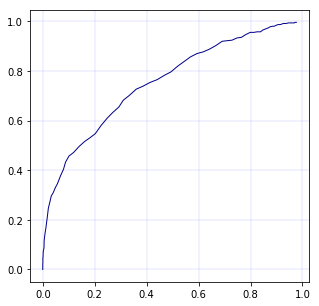

In [145]:
fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(111)
ax.plot(FPR, TPR, color='darkblue', linewidth=1)
ax.grid(color='b', linestyle='-', linewidth=0.1)
plt.show()

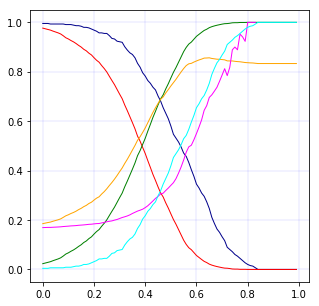

In [146]:
fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(111)
ax.plot(thresholdValues, TPR, color='darkblue', linewidth=1)
ax.plot(thresholdValues, FPR, color='red', linewidth=1)
ax.plot(thresholdValues, TNR, color='green', linewidth=1)
ax.plot(thresholdValues, ACC, color='orange', linewidth=1)
ax.plot(thresholdValues, PPV, color='magenta', linewidth=1)
ax.plot(thresholdValues, FNR, color='cyan', linewidth=1)
ax.grid(color='b', linestyle='-', linewidth=0.1)
plt.show()

In [147]:
gestures = Measurement.getFeatures(examinationData.filterData(lambda x : True))   
X = np.array(gestures)

pca = PCA(n_components = 4)
principalComponents  = pca.fit_transform(X)

principalDf = pd.DataFrame(data = principalComponents,
                           columns = ['principal component 1',
                                      'principal component 2', 
                                      'principal component 3',
                                      'principal component 4'])

IDs = pd.DataFrame(list(map(lambda x: x.gestureId, examinationData.filterData(lambda x : True))),
                  columns=["gest"])

temp = [principalDf, IDs]
finalDf = pd.concat(temp, axis = 1)

targets = ['gest1', 'gest2', 'gest3', 'gest4', 'gest5', 'gest6']
colors = ['r', 'g', 'b', 'y', 'c', 'k']

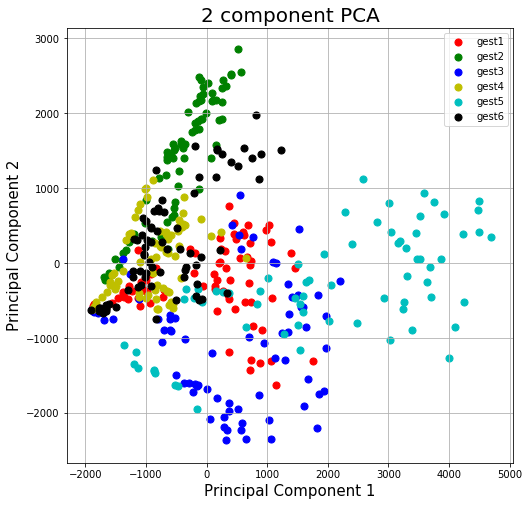

In [148]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
for target, color in zip(targets,colors):
    indicesToKeep = finalDf['gest'] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'principal component 1'],
               finalDf.loc[indicesToKeep, 'principal component 2'],
               c = color,
               s = 50)
ax.legend(targets)
ax.grid()
plt.show()

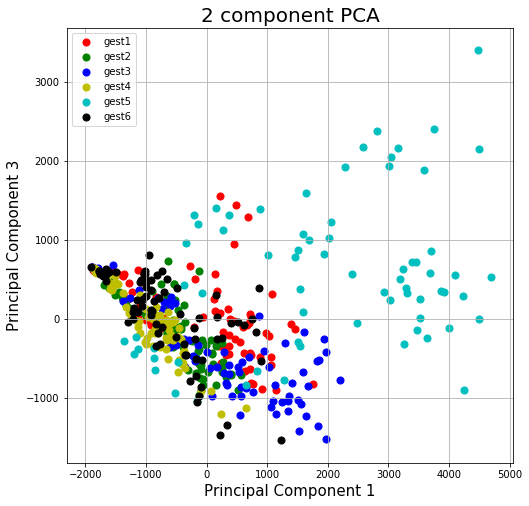

In [149]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 3', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
for target, color in zip(targets,colors):
    indicesToKeep = finalDf['gest'] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'principal component 1'],
               finalDf.loc[indicesToKeep, 'principal component 3'],
               c = color,
               s = 50)
ax.legend(targets)
ax.grid()
plt.show()

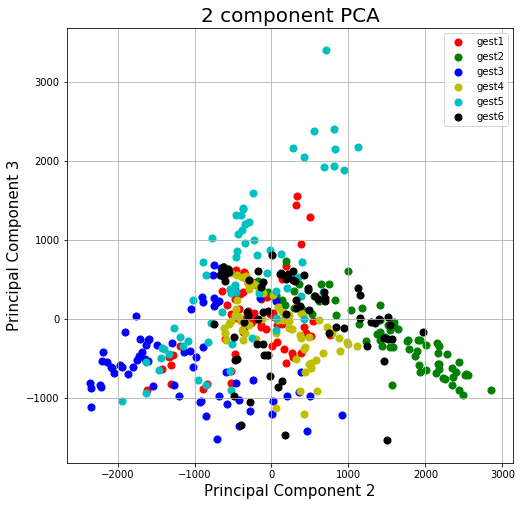

In [150]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 2', fontsize = 15)
ax.set_ylabel('Principal Component 3', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
for target, color in zip(targets,colors):
    indicesToKeep = finalDf['gest'] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'principal component 2'],
               finalDf.loc[indicesToKeep, 'principal component 3'],
               c = color,
               s = 50)
ax.legend(targets)
ax.grid()
plt.show()

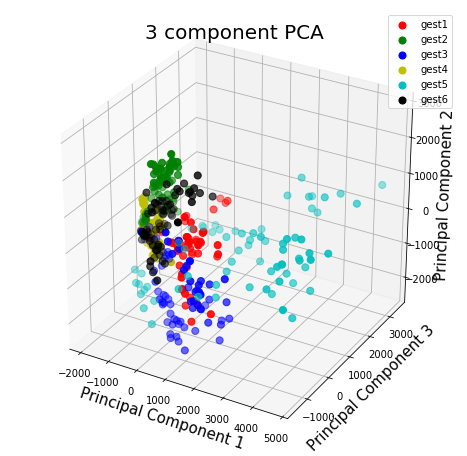

In [151]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1, projection='3d') 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 3', fontsize = 15)
ax.set_zlabel('Principal Component 2', fontsize = 15)
ax.set_title('3 component PCA', fontsize = 20)

for target, color in zip(targets,colors):
    indicesToKeep = finalDf["gest"] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'principal component 1'],
               finalDf.loc[indicesToKeep, 'principal component 3'],
               finalDf.loc[indicesToKeep, 'principal component 2'],
               c = color,
               s = 50)
ax.legend(targets)
ax.grid()

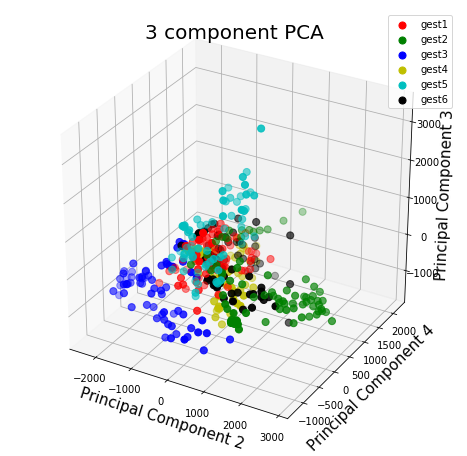

In [152]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1, projection='3d') 
ax.set_xlabel('Principal Component 2', fontsize = 15)
ax.set_ylabel('Principal Component 4', fontsize = 15)
ax.set_zlabel('Principal Component 3', fontsize = 15)
ax.set_title('3 component PCA', fontsize = 20)

for target, color in zip(targets,colors):
    indicesToKeep = finalDf["gest"] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'principal component 2'],
               finalDf.loc[indicesToKeep, 'principal component 4'],
               finalDf.loc[indicesToKeep, 'principal component 3'],
               c = color,
               s = 50)
ax.legend(targets)
ax.grid()

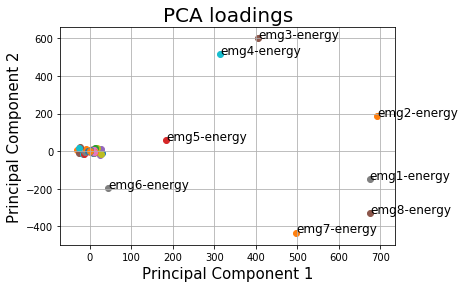

In [153]:
pcaLoadings = pca.components_.T * np.sqrt(pca.explained_variance_)
featuresList = ["".join((header._name_,'-',feature._name_)) for header in Channel for feature in FeaturesEnum]

fig = plt.figure()
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('PCA loadings', fontsize = 20)

for i in range (len(featuresList)) : 
    ax.scatter(pcaLoadings[i][0],
               pcaLoadings[i][1])
    
    if math.fabs(pcaLoadings[i][0]) > 30 or math.fabs(pcaLoadings[i][1] > 30) : 
        ax.text(pcaLoadings[i][0], pcaLoadings[i][1], featuresList[i], fontsize=12)
    
ax.grid()
plt.show()

Text(0.5,1,'Wykres osuwiska')

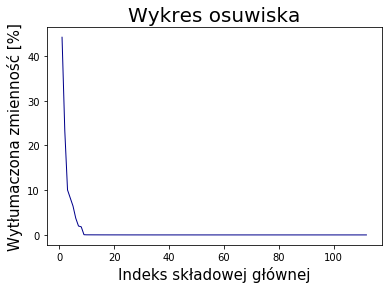

In [154]:
# Rozszerzenie projektu - machine learning

pca = PCA()
principalComponents  = pca.fit_transform(X)
explainedVariance = pca.explained_variance_ / sum(pca.explained_variance_) * 100

fig = plt.figure()
ax = fig.add_subplot(1,1,1) 
ax.plot(np.linspace(1, len(explainedVariance), len(explainedVariance)),
        explainedVariance, color='darkblue', linewidth=1)
ax.set_xlabel('Indeks składowej głównej', fontsize = 15)
ax.set_ylabel('Wytłumaczona zmienność [%]', fontsize = 15)
ax.set_title('Wykres osuwiska', fontsize = 20)


In [155]:
#Wybranie składowych o zmienności większej niz 1% - wejście algorytmu

thresholdIndex = \
    explainedVariance.tolist().index(next(x for x in explainedVariance if x < 1 )) + 1

In [156]:
thresholdIndex

9

In [157]:
#Przygotowanie danych

pca = PCA(n_components = thresholdIndex)
principalComponents  = pca.fit_transform(X)

IDs = pd.DataFrame(list(map(lambda x: x.gestureId, examinationData.filterData(lambda x : True))),
                  columns=["gest"])

columnNames = [];

for i in range(1,thresholdIndex + 1):
    columnNames.append("Principal Component " + str(i))
    

principalDf = pd.DataFrame(data = principalComponents,
                           columns = columnNames)

temp = [principalDf, IDs]
dataToAnalysis = pd.concat(temp, axis = 1)

In [158]:
# Podzielenie danych na dwa zbiory - trenujący i walidacyjny
    
array = dataToAnalysis.values
X = array[:,0 : thresholdIndex-1]
Y = array[:,thresholdIndex]
validation_size = 0.20
seed = 7
scoring = 'accuracy'
X_train, X_validation, Y_train, Y_validation = \
    model_selection.train_test_split(X, Y, test_size=validation_size, random_state=seed)

In [164]:
#Ocena poszczegolnych modeli
models = []
models.append(('LR', LogisticRegression()))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC()))

results = []
meanResult = []
names = []
for name, model in models:
    kfold = model_selection.KFold(n_splits=10, random_state=seed)
    cv_results = model_selection.cross_val_score(model, X_train, Y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    meanResult.append(cv_results.mean())
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

LR: 0.794524 (0.058358)
LDA: 0.730079 (0.077072)
KNN: 0.873254 (0.057156)
CART: 0.788889 (0.072623)
NB: 0.707540 (0.071445)


D:\Users\kluska\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


SVM: 0.123889 (0.043120)


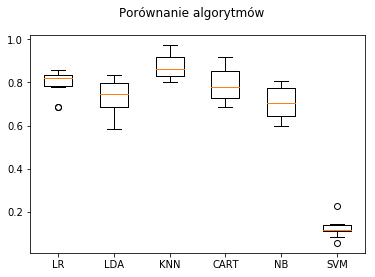

In [165]:
# Porównanie algorytmów
fig = plt.figure()
fig.suptitle('Porównanie algorytmów')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

In [174]:
# Predykcja na zbiorze walidacyjnym
bestAlgorithmIndex = meanResult.index(np.max(meanResult))
bestAlgorithmToValidation = models[bestAlgorithmIndex][1]

bestAlgorithmToValidation.fit(X_train, Y_train)
predictions = bestAlgorithmToValidation.predict(X_validation)
print("Confusion matrix")
print(confusion_matrix(Y_validation, predictions))
print("\n\n{}\n{}".format("Tabela wyników", classification_report(Y_validation, predictions)))



Confusion matrix
[[10  1  1  1  1  0]
 [ 0  8  0  0  0  1]
 [ 0  0 14  2  0  0]
 [ 1  0  0 17  0  1]
 [ 0  0  0  1 16  0]
 [ 0  3  0  0  0 12]]


Tabela wyników
             precision    recall  f1-score   support

      gest1       0.91      0.71      0.80        14
      gest2       0.67      0.89      0.76         9
      gest3       0.93      0.88      0.90        16
      gest4       0.81      0.89      0.85        19
      gest5       0.94      0.94      0.94        17
      gest6       0.86      0.80      0.83        15

avg / total       0.87      0.86      0.86        90

